<a href="https://colab.research.google.com/github/yusuftarkgun/DataAnalycsis/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import sys
import random
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from sklearn import preprocessing
from sklearn.preprocessing import scale
import tensorflow as tf
from tensorflow import keras

Bu kod parçası, çeşitli Python kütüphanelerini içe aktararak, veri işleme, görüntü işleme, makine öğrenimi ve derin öğrenme işlemleri için temel fonksiyonları sağlar.

In [4]:
N_train = [2500,2500,2500,2500,2500,2500]
N_test_start = [2500,2500,2500,2500,2500,2500]
N_test = [250,250,250,250,250,250]
N_class = len(N_train)
data_sizeX = 200
data_sizeY = 600
mask_sizeX = 256
mask_sizeY = 256
num_channel = 1
train_data1 = []
train_data2 = []
train_mask= []
test_data1 = []
test_data2 = []
test_mask = []
path = '/Users/yusuftarikgun/Desktop/'
sub_path = ''

Bu kod parçası, belirtilen boyutlarda ve sınıf sayısında eğitim ve test veri setlerini oluşturmak için kullanılacak parametreleri ve depolama yapılarını tanımlar.

In [ ]:
# Load data
for i in range(N_class):
    for j in range(N_train[i]):
        data1 = sio.loadmat(path+'dataset/%d/data1/%d.mat'%(i+1, j+1))['data1']
        train_data1.append(data1.reshape((data_sizeX,data_sizeY,1)))
        data2 = sio.loadmat(path+'dataset/%d/data2/%d.mat'%(i+1, j+1))['data2']
        train_data2.append(data2.reshape((data_sizeX,data_sizeY,1)))
        mask = sio.loadmat(path+'dataset/%d/mask/%d.mat'%(i+1, j+1))['mask']
        train_mask.append(mask.reshape((mask_sizeX,mask_sizeY,1)))

    for j in range(N_test_start[i], N_test_start[i]+N_test[i]):
        data1 = sio.loadmat(path+'dataset/%d/data1/%d.mat'%(i+1, j+1))['data1']
        test_data1.append(data1.reshape((data_sizeX,data_sizeY,1)))
        data2 = sio.loadmat(path+'dataset/%d/data2/%d.mat'%(i+1, j+1))['data2']
        test_data2.append(data2.reshape((data_sizeX,data_sizeY,1)))
        mask = sio.loadmat(path+'dataset/%d/mask/%d.mat'%(i+1, j+1))['mask']
        test_mask.append(mask.reshape((mask_sizeX,mask_sizeY,1)))


        train_data1 = np.array(train_data1)
        train_data2 = np.array(train_data2)
        train_mask = np.array(train_mask)
        test_data1 = np.array(test_data1)
        test_data2 = np.array(test_data2)
        test_mask = np.array(test_mask)

Bir veri setini yüklemek, boyutlandırmak ve eğitim/test veri setlerine ayırmak için kullanılan temel adımları içerir.

In [ ]:
# Build model
def cross_attention(x1, x2, filters, h=8):
    v1 = keras.layers.Conv2D(filters, (1,1), padding='same', strides=1)(x1)
    q2 = keras.layers.Conv2D(filters, (1,1), padding='same', strides=1)(x2)
    a1 = keras.layers.MultiHeadAttention(num_heads=h, key_dim=filters//h)(q2, v1)
    o1 = keras.layers.LayerNormalization()(a1 + v1)
    out1 = keras.layers.LayerNormalization()(o1 + keras.layers.Conv2D(filters, (1,1), padding='same', strides=1)(o1))
    return out1

def down_block(x, filters, kernel_size=(3,3), padding='same', strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    c = keras.layers.Activation('relu')(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(c)
    c = keras.layers.Activation('relu')(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return p

def connect_block(x, filters, kernel_size=(3,3)):
    c = keras.layers.Conv2D(filters, kernel_size, padding='same', strides=(1,3))(x)
    c = keras.layers.Activation('relu')(c)
    c = keras.layers.Conv2DTranspose(filters, kernel_size, padding='valid', strides=1)(c)
    c = keras.layers.Activation('relu')(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding='same', strides=1)(c)
    c = keras.layers.Activation('relu')(c)
    return c

def up_block(x, filters, kernel_size=(3,3), padding='same', strides=1):
    us_x = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(us_x)
    c = keras.layers.Activation('relu')(c)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(c)
    c = keras.layers.Activation('relu')(c)
    return c


Bu fonksiyonlar, farklı özellikleri çıkaran, ölçekleyen ve birleştiren bir modelin temel yapı taşlarını oluşturur.

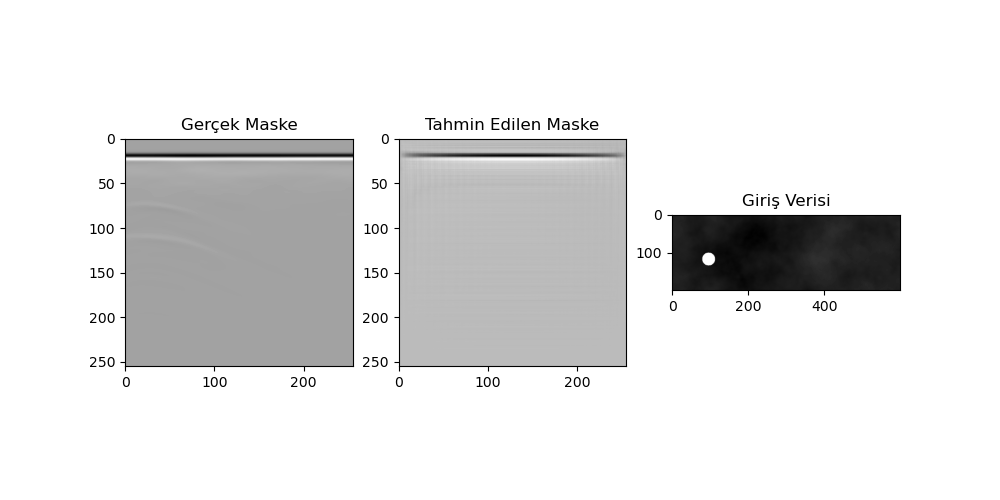

In [ ]:
def network():

    # Feature Map Channel
    f0 = 16
    f = [f0, f0*2, f0*4, f0*8, f0*16, f0*32]
    inputs1 = keras.layers.Input((data_sizeX, data_sizeY, num_channel))
    inputs2 = keras.layers.Input((data_sizeX, data_sizeY, num_channel))

    # Encoder1
    p10 = inputs1
    p11 = down_block(p10, f[0])
    p12 = down_block(p11, f[1])
    p13 = down_block(p12, f[2])
    p14 = down_block(p13, f[3])
    e1 = down_block(p14, f[4])

    # Encoder2
    p20 = inputs2
    p21 = down_block(p20, f[0])
    p22 = down_block(p21, f[1])
    p23 = down_block(p22, f[2])
    p24 = down_block(p23, f[3])
    e2 = down_block(p24, f[4])

    # Fusion
    fu1 = cross_attention(e1, e2, f[4])
    fu2 = cross_attention(e2, e1, f[4])
    fu = connect_block(keras.layers.Concatenate()([fu1, fu2]), f[5])

    # Decoder
    u1 = up_block(fu, f[4])
    u2 = up_block(u1, f[3])
    u3 = up_block(u2, f[2])
    u4 = up_block(u3, f[1])
    u5 = up_block(u4, f[0])

    outputs = keras.layers.Conv2D(1, (1, 1), padding='same')(u5)
    model = tf.keras.Model([inputs1, inputs2], outputs)

    return model

def get_lr_metric(optimizer):
    def learning_rate(y_true, y_pred):
        return optimizer.learning_rate
    return learning_rate

model = network()
model.summary()

Bu modelin genel amacı, iki giriş veri seti arasındaki ilişkileri öğrenmek ve çıkışta bir segmentasyon veya benzeri bir görev gerçekleştirmektir.

In [ ]:
# Training
total_epoch = 1
batch_size = 10
model_path = path+sub_path+'model.h5'
Adam = keras.optimizers.Adam(learning_rate=1e-4)
lr_metric = get_lr_metric(Adam)
model.compile(optimizer=Adam, loss='mse', metrics=[lr_metric])
model_checkpoint = keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
lr_checkpoint = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.98, patience=1, min_lr=0)
history = model.fit(x=[train_data1,train_data2], y=train_mask, batch_size=batch_size, epochs=total_epoch, verbose=2, \
    validation_data=([test_data1,test_data2], test_mask), callbacks=[model_checkpoint,lr_checkpoint])


Bu kod, derin öğrenme modelinin eğitim sürecini başlatan ve eğitim sırasında kontrol noktalarını ve öğrenme oranı ayarlamalarını sağlayan önemli bir bölümü içerir.


---





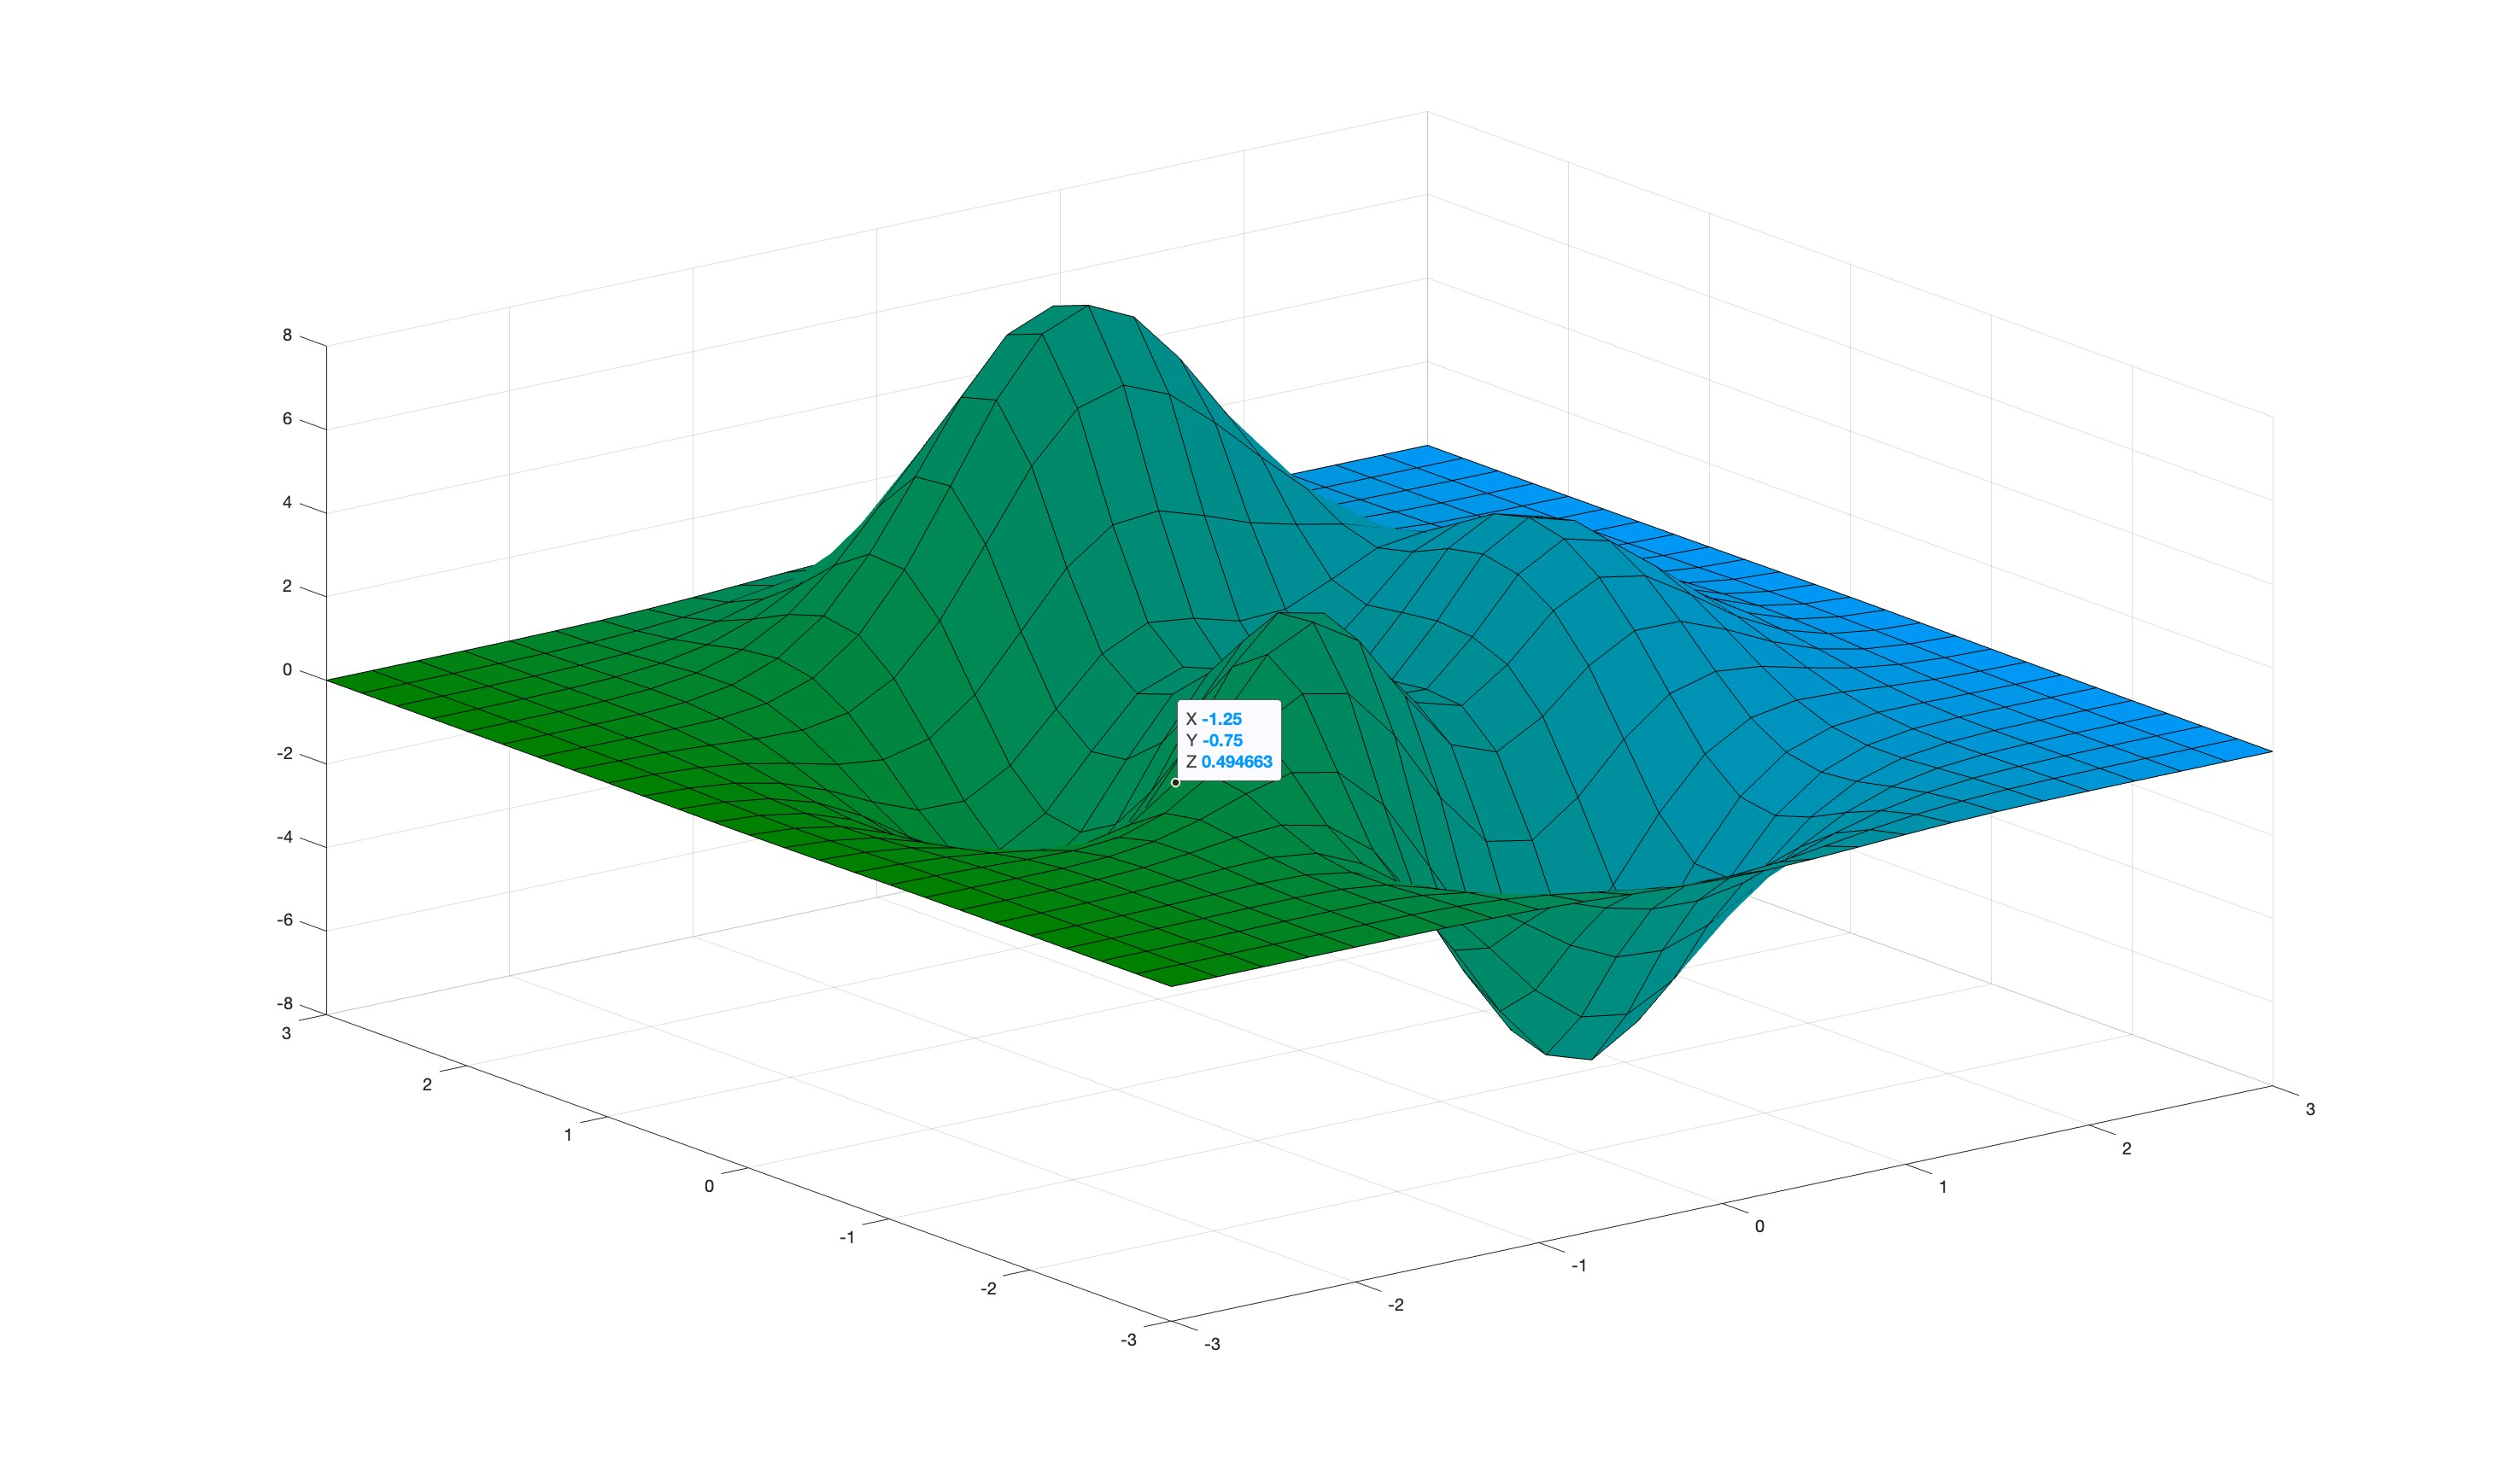

In [ ]:
# Testing
model.load_weights(model_path)
model.evaluate(x=[test_data1,test_data2], y=test_mask, batch_size=batch_size)
test_pred = model.predict([test_data1,test_data2])
sio.savemat(path+sub_path+'data1.mat', {'data1': test_data1})
sio.savemat(path+sub_path+'data2.mat', {'data2': test_data2})
sio.savemat(path+sub_path+'mask.mat', {'mask': test_mask})
sio.savemat(path+sub_path+'pred.mat', {'pred': test_pred})

Bu kod, eğitilen modelin performansını test etmek için kullanılır ve elde edilen sonuçları kaydeder.

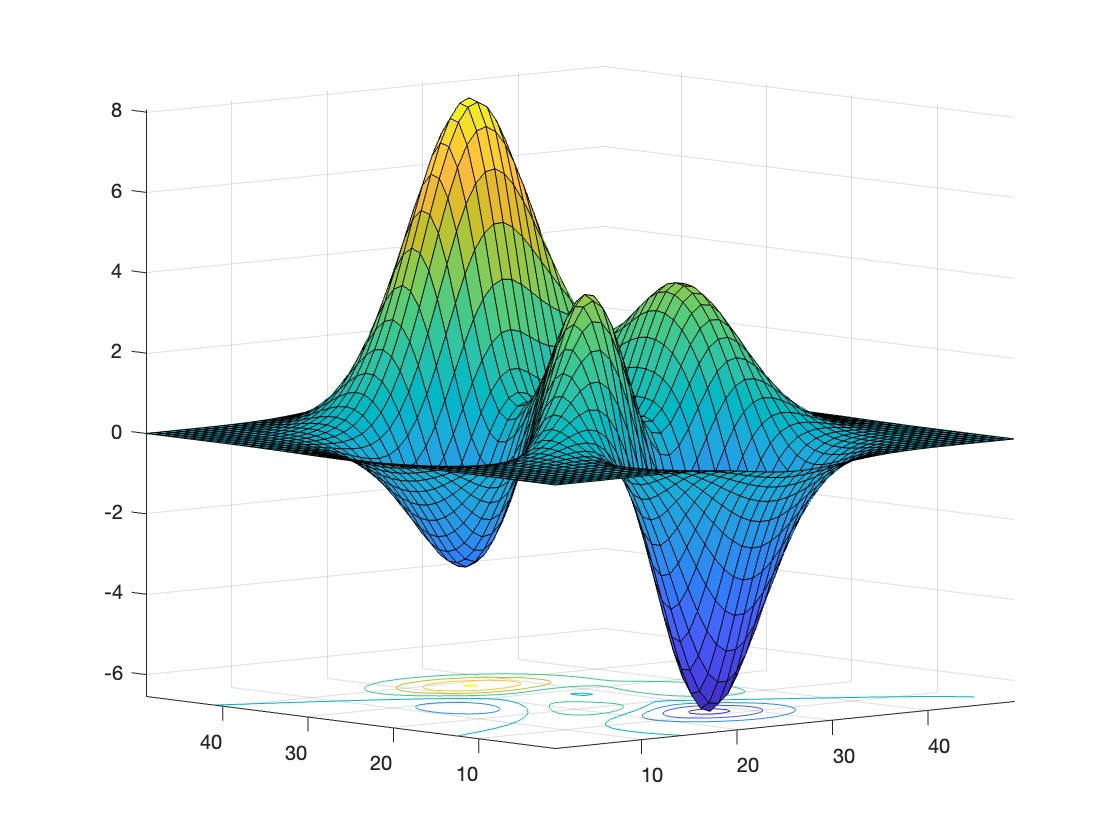